In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [3]:
%load_ext watermark

In [4]:
%watermark --iversions

altair    4.0.1
pandas    1.1.0
numpy     1.18.1
xarray    0.14.1



In [5]:
from utils.load import load_dilution_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors, rms_errors, spearman_errors)

# 1. Load the simulation data

In [6]:
dil_df, debug_info = load_dilution_data()

In [7]:
dil_df.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.054344,ACALD,ACALD,Khodayari,0.2,-0.049474
1,-0.004107,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,0.2,-0.003739
2,0.088129,ACKr,ACKr,Khodayari,0.2,0.080232
3,96.831733,ACONTa,ACONTa,Khodayari,0.2,88.154691
4,96.797201,ACONTb,ACONTb,Khodayari,0.2,88.123254


In [8]:
dil_df.sample_id = dil_df.sample_id.astype('str')

In [9]:
dil_df.query("author == 'Yao'").BiGG_ID.unique()

array(['GLCptspp', 'PGI', 'PFK', 'FBA', 'GAPD', 'PGK', 'PGM', 'ENO',
       'PYK', 'PDH', 'PTAr', 'ACKr', 'ACt2r', 'PPC', 'CS', 'ACONTa',
       'ACONTb', 'ICDHyr', 'AKGDH', 'SUCOAS', 'SUCDi', 'FUM', 'ME1',
       'ICL', 'MDH', 'NADTRHD', 'G6PDH2r', 'GND', 'RPE', 'RPI', 'TKT1',
       'TKT2', 'TALA', 'PGCD', 'GHMT2r'], dtype=object)

### Preprocess data

In [10]:
xdf = process_data(dil_df, author="Yao")

# 2. Calculate error metrics

In [11]:
x_rel_error = relative_errors(xdf, author="Yao")

In [12]:
x_norm_error = summary_errors(xdf, author="Yao")

In [13]:
x_rms_error = rms_errors(xdf, author="Yao")

In [14]:
x_spearman_error = spearman_errors(xdf, author="Yao")

# 3. Visualize

In [15]:
from utils.vis import heatmap, jitter_summary_chart

In [16]:
def dilution_plot(source, field="normalized_error", field_name="Normalized error"):
    domain = [
        "Khodayari",
        "Millard",
        "Kurata",
        "iML1515",
        "Chassagnole",
        "Exp_iML1515",
    ]
    range_ = [
        "#1b9e77",
        "#d95f02",
        "#7570b3",
        "#e7298a",
        "#66a61e",
        "#e6ab02",
    ]

    author = "Yao"
    sort_list = ["Chassagnole", "Khodayari", "Millard", "Kurata", "iML1515"]

    source = source.to_dataframe().reset_index()
    if type(author) == list:
        source = source.query(f"author not in @author")
    elif type(author) == str:
        source = source.query(f"author != '{author}'")

    selector = alt.selection_single(empty="none", fields=["sample_id"])

    opacity = alt.OpacityValue(1.0)

    size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(90))


    stripplot = (
        alt.Chart(width=100, height=600)
        .mark_circle()
        .encode(
            x=alt.X("sample_id:O", title=None, scale=alt.Scale(),),
            y=alt.Y(f"{field}:Q", title=f"{field_name}", axis=alt.Axis(tickCount=8)),
            color=alt.Color(
                "author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)
            ),
            size=size,
            opacity=opacity,
            tooltip=["author", "sample_id", f"{field}"],
        )
        .add_selection(selector)
    )

    line_plot = (
        alt.Chart()
        .mark_line()
        .encode(
            x=alt.X("sample_id:O", title=None, scale=alt.Scale(),),
            y=alt.Y(f"{field}:Q", title=f"{field_name}",axis=alt.Axis(tickCount=8)),
            color=alt.Color(
                "author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)
            ),
        )
    )


    mean_tick = (
        alt.Chart()
        .mark_tick(width = 50)
        .encode(
            y = alt.Y(f"mean({field})"),
            color=alt.Color(
                "author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)
            ),
        )
    )

    layer = (
        alt.layer(stripplot, line_plot, mean_tick, data=source)
        .facet(
            column=alt.Column(
                "author:N",
                header=alt.Header(
                    labelAngle=-90,
                    titleOrient="top",
                    labelOrient="bottom",
                    labelAlign="right",
                    labelPadding=3,
                    labelFontSize=20,
                ),
                sort=sort_list,
            )
        )
        .configure_facet(spacing=5)
        .configure_view(stroke=None)
        .transform_filter(f"datum.{field} !== null")
    )

    return layer.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(
        titleFontSize=24
    )

In [17]:
dilution_plot(source=x_norm_error)

alt.FacetChart(...)

In [18]:
dilution_plot(source=x_rms_error, field="RMSE", field_name="RMSE")

alt.FacetChart(...)

In [21]:
dilution_plot(source=x_spearman_error, field="SpearmanR", field_name="SpearmanR")

alt.FacetChart(...)

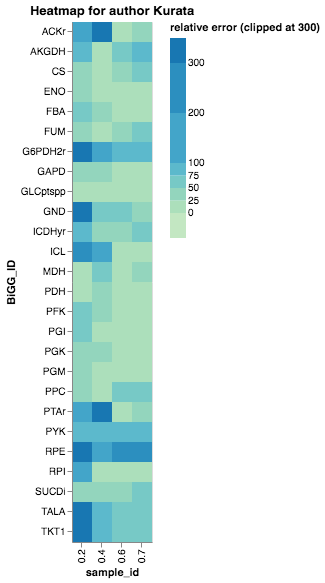

In [16]:
heatmap(x_rel_error, author = "Kurata")

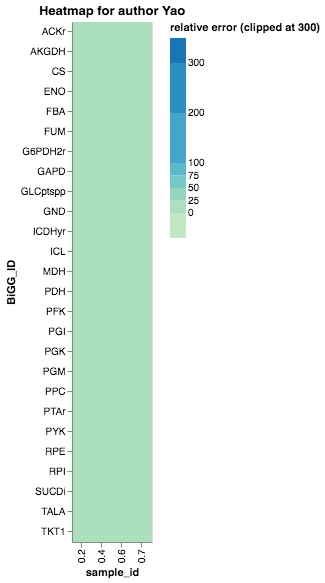

In [15]:
heatmap(x_rel_error, author = "Yao")